In [78]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np

df = yf.download('RELIANCE.NS', start='2020-01-01', end='2025-06-22', group_by='column')
print(df.columns)

[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'RELIANCE.NS'),
            (  'High', 'RELIANCE.NS'),
            (   'Low', 'RELIANCE.NS'),
            (  'Open', 'RELIANCE.NS'),
            ('Volume', 'RELIANCE.NS')],
           names=['Price', 'Ticker'])


In [79]:
data.isnull().sum()

Price
Close    0
dtype: int64

In [80]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df_subset = df[features]

In [81]:
train_size = int(len(df_subset) * 0.8)
train_data = df_subset.iloc[:train_size]
test_data = df_subset.iloc[train_size:]

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

In [83]:
import numpy as np

def create_sequences(data, window_size=2, target_col=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])  # 60 rows of 5 features
        y.append(data[i + window_size, target_col])  # Next day's Adj Close
    return np.array(X), np.array(y)

# Parameters
WINDOW_SIZE = 60  # 60-day lookback
TARGET_COL = 3  # Index of 'Adj Close' in ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Create sequences for training and testing
X_train, y_train = create_sequences(scaled_train, WINDOW_SIZE, TARGET_COL)
X_test, y_test = create_sequences(scaled_test, WINDOW_SIZE, TARGET_COL)

# Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1024, 60, 5), y_train shape: (1024,)
X_test shape: (211, 60, 5), y_test shape: (211,)


In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(WINDOW_SIZE, 5)),
    Dropout(0.2),
    Dense(1)  # Predict Adj Close
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.1169 - val_loss: 0.0344
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0107 - val_loss: 0.0096
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0066 - val_loss: 0.0072
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0054 - val_loss: 0.0067
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0

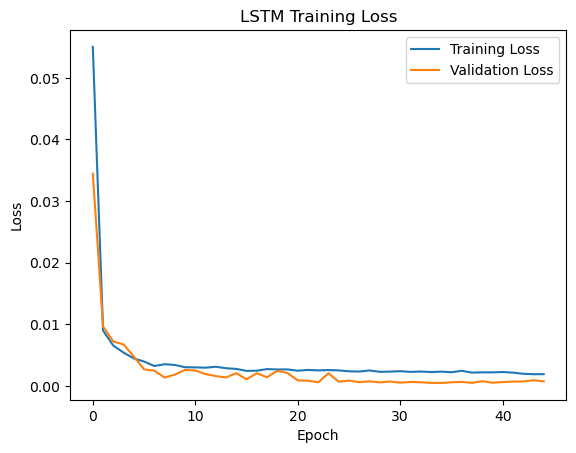

In [85]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Save model
model.save('lstm_reliance.h5')

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0021 - val_loss: 5.8955e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - val_loss: 9.2426e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0022 - val_loss: 6.2143e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - val_loss: 4.3978e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 4.8612e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019 - val_loss: 6.2064e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 6.5946e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021 - val_loss: 4.8921e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 6.8948e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 6.1223e-04
Epoch 12/50
26/26 ━━━━━

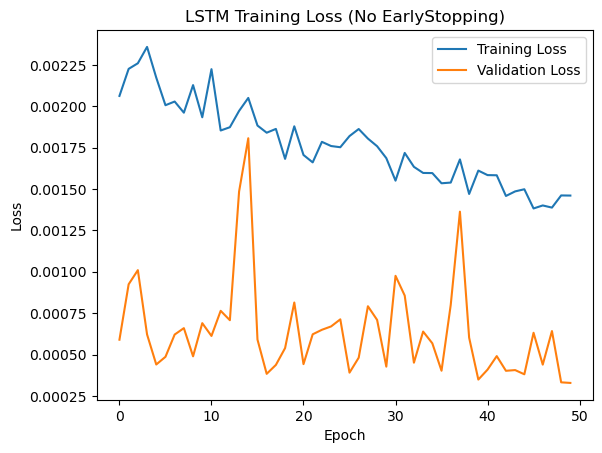

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
RMSE (No EarlyStopping): 25.31 INR, MAE: 19.61 INR


In [86]:
# Retrain model without EarlyStopping
history_no_es = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Save new model
model.save('lstm_reliance_no_es.h5')

# Plot new loss curves
plt.plot(history_no_es.history['loss'], label='Training Loss')
plt.plot(history_no_es.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss (No EarlyStopping)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate new model
y_pred_no_es = model.predict(X_test)
y_pred_padded_no_es = np.zeros((y_pred_no_es.shape[0], 5))
y_pred_padded_no_es[:, 3] = y_pred_no_es.flatten()
y_pred_no_es_inr = scaler.inverse_transform(y_pred_padded_no_es)[:, 3]
rmse_no_es = np.sqrt(mean_squared_error(y_test_inr, y_pred_no_es_inr))
mae_no_es = mean_absolute_error(y_test_inr, y_pred_no_es_inr)
print(f'RMSE (No EarlyStopping): {rmse_no_es:.2f} INR, MAE: {mae_no_es:.2f} INR')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0014 - val_loss: 3.2644e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - val_loss: 3.4221e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - val_loss: 3.4567e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 3.2465e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012 - val_loss: 3.9022e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0012 - val_loss: 3.6812e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 3.5220e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0013 - val_loss: 3.3062e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0013 - val_loss: 3.1733e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0012 - val_loss: 3.3642e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0014 - val_loss: 3.8683e-04
Epoch 12/50
26/26 ━

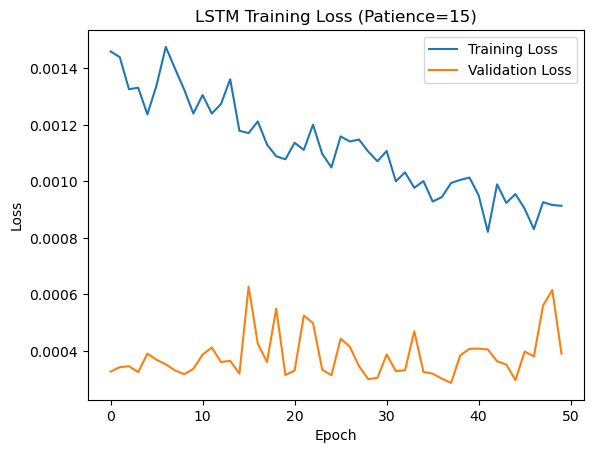

In [87]:
from tensorflow.keras.callbacks import EarlyStopping

# Retrain with higher patience
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history_high_patience = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Save model
model.save('lstm_reliance_high_patience.h5')

# Plot loss
plt.plot(history_high_patience.history['loss'], label='Training Loss')
plt.plot(history_high_patience.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss (Patience=15)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Patience=10 - RMSE: 31.16 INR, MAE: 24.10 INR
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
No EarlyStopping - RMSE: 25.31 INR, MAE: 19.61 INR
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Patience=15 - RMSE: 23.14 INR, MAE: 17.77 INR


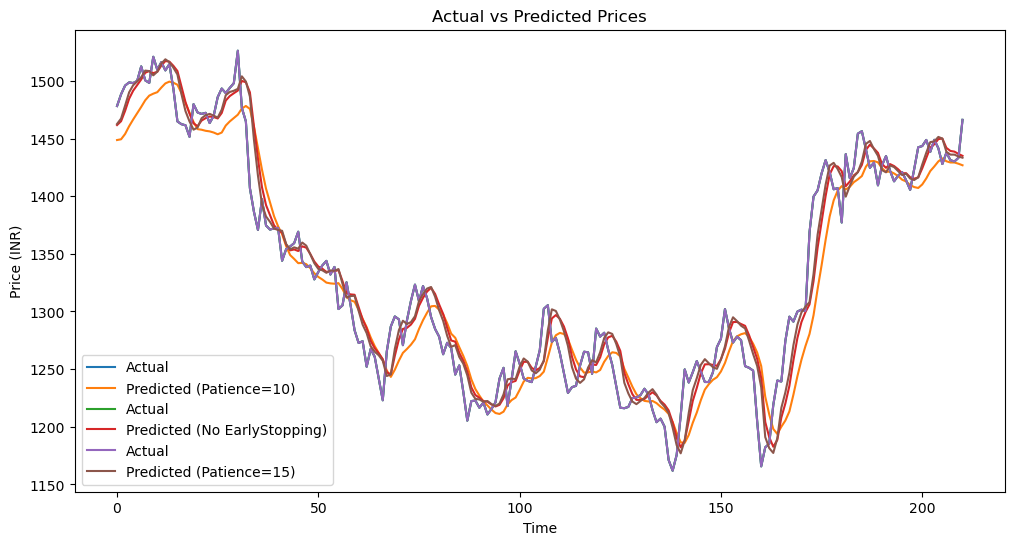

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

# Load models (adjust paths as needed)
model_p10 = load_model('lstm_reliance.h5')  # patience=10
model_no_es = load_model('lstm_reliance_no_es.h5')  # no EarlyStopping
model_p15 = load_model('lstm_reliance_high_patience.h5')  # patience=15

# Function to evaluate and plot
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_pred_padded = np.zeros((y_pred.shape[0], 5))
    y_test_padded = np.zeros((y_test.shape[0], 5))
    y_pred_padded[:, 3] = y_pred.flatten()
    y_test_padded[:, 3] = y_test
    y_pred_inr = scaler.inverse_transform(y_pred_padded)[:, 3]
    y_test_inr = scaler.inverse_transform(y_test_padded)[:, 3]
    rmse = np.sqrt(mean_squared_error(y_test_inr, y_pred_inr))
    mae = mean_absolute_error(y_test_inr, y_pred_inr)
    print(f'{name} - RMSE: {rmse:.2f} INR, MAE: {mae:.2f} INR')
    plt.plot(y_test_inr, label='Actual')
    plt.plot(y_pred_inr, label=f'Predicted ({name})')
    return y_pred_inr

# Evaluate and plot
plt.figure(figsize=(12, 6))
y_pred_p10 = evaluate_model(model_p10, 'Patience=10')
y_pred_no_es = evaluate_model(model_no_es, 'No EarlyStopping')
y_pred_p15 = evaluate_model(model_p15, 'Patience=15')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0010 - val_loss: 2.9600e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 9.1497e-04 - val_loss: 2.9087e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 9.3567e-04 - val_loss: 2.8313e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 9.3588e-04 - val_loss: 3.5754e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 8.6926e-04 - val_loss: 5.1089e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.5075e-04 - val_loss: 3.9570e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8.9436e-04 - val_loss: 3.5368e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.2541e-04 - val_loss: 2.9550e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0010 - val_loss: 3.1337e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 8.4610e-04 - val_loss: 4.6711e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.6901e-04 - val_

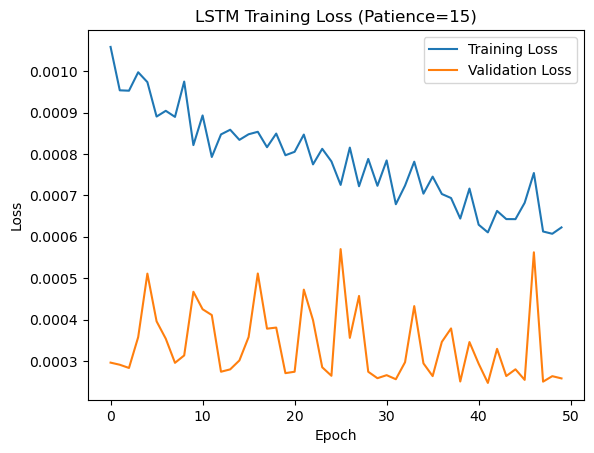

In [89]:
# Retrain with higher patience
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_high_patience = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot loss
plt.plot(history_high_patience.history['loss'], label='Training Loss')
plt.plot(history_high_patience.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss (Patience=15)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [90]:
# === IMPROVED MODEL (New Architecture) ===

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


In [92]:
def create_improved_lstm_model(input_shape, learning_rate=0.001):
    """
    Create an improved LSTM model with better architecture
    """
    model = Sequential([
        # First LSTM layer - return sequences for stacking
        LSTM(100, return_sequences=True, input_shape=input_shape,
             dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        
        # Second LSTM layer - return sequences for stacking
        LSTM(80, return_sequences=True,
             dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        
        # Third LSTM layer - no return sequences (final layer)
        LSTM(60, return_sequences=False,
             dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        
        # Dense layers for final prediction
        Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(25, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(1, activation='linear')  # Linear for regression
    ])
    
    # Compile with custom optimizer
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)  # Gradient clipping
    model.compile(
        optimizer=optimizer,
        loss='huber',  # More robust to outliers than MSE
        metrics=['mae', 'mse']
    )
    
    return model

# Create the improved model
improved_model = create_improved_lstm_model((WINDOW_SIZE, 5))
improved_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 60, 80)         │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 60, 80)         │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 60)             │        33,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60)             │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,471 (544.81 KB)

 Trainable params: 138,991 (542.93 KB)

 Non-trainable params: 480 (1.88 KB)

In [93]:
def create_callbacks(model_name='improved_lstm'):
    """
    Create callbacks for better training control
    """
    callbacks = [
        # Early stopping with more patience
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.0001
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1,
            cooldown=5
        ),
        
        # Save best model
        ModelCheckpoint(
            f'{model_name}_best.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    return callbacks

# Create callbacks
callbacks = create_callbacks('improved_lstm_reliance')
print("Callbacks created successfully!")

Callbacks created successfully!


In [94]:
print("Starting training...")
print(f"Training data shape: {X_train.shape}")
print(f"Validation split will create ~{int(len(X_train) * 0.2)} validation samples")

# Train the improved model
history_improved = improved_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  # More epochs with better early stopping
    batch_size=16,  # Smaller batch size for more stable training
    callbacks=callbacks,
    verbose=1,
    shuffle=False  # Important for time series!
)

print("Training completed!")

Starting training...
Training data shape: (1024, 60, 5)
Validation split will create ~204 validation samples
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2967 - mae: 0.5277 - mse: 0.4494
Epoch 1: val_loss improved from inf to 0.33891, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - loss: 0.2959 - mae: 0.5265 - mse: 0.4476 - val_loss: 0.3389 - val_mae: 0.7087 - val_mse: 0.5143 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1945 - mae: 0.3754 - mse: 0.2302
Epoch 2: val_loss improved from 0.33891 to 0.25193, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 0.1941 - mae: 0.3748 - mse: 0.2294 - val_loss: 0.2519 - val_mae: 0.5784 - val_mse: 0.3465 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1457 - mae: 0.2896 - mse: 0.1360
Epoch 3: val_loss improved from 0.25193 to 0.19017, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - loss: 0.1456 - mae: 0.2894 - mse: 0.1357 - val_loss: 0.1902 - val_mae: 0.4695 - val_mse: 0.2287 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1390 - mae: 0.2774 - mse: 0.1281
Epoch 4: val_loss improved from 0.19017 to 0.18939, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.1388 - mae: 0.2771 - mse: 0.1277 - val_loss: 0.1894 - val_mae: 0.4683 - val_mse: 0.2324 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1294 - mae: 0.2638 - mse: 0.1144
Epoch 5: val_loss improved from 0.18939 to 0.14119, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.1291 - mae: 0.2632 - mse: 0.1139 - val_loss: 0.1412 - val_mae: 0.3623 - val_mse: 0.1411 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1224 - mae: 0.2548 - mse: 0.1053
Epoch 6: val_loss improved from 0.14119 to 0.11775, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.1221 - mae: 0.2544 - mse: 0.1049 - val_loss: 0.1177 - val_mae: 0.2968 - val_mse: 0.0993 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1182 - mae: 0.2407 - mse: 0.1018
Epoch 7: val_loss improved from 0.11775 to 0.11150, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.1179 - mae: 0.2402 - mse: 0.1013 - val_loss: 0.1115 - val_mae: 0.2836 - val_mse: 0.0917 - learning_rate: 0.0010
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1093 - mae: 0.2336 - mse: 0.0888
Epoch 8: val_loss improved from 0.11150 to 0.11055, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 0.1090 - mae: 0.2329 - mse: 0.0883 - val_loss: 0.1105 - val_mae: 0.2856 - val_mse: 0.0948 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1037 - mae: 0.2180 - mse: 0.0826
Epoch 9: val_loss improved from 0.11055 to 0.09916, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.1035 - mae: 0.2175 - mse: 0.0821 - val_loss: 0.0992 - val_mae: 0.2625 - val_mse: 0.0767 - learning_rate: 0.0010
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0995 - mae: 0.2207 - mse: 0.0789
Epoch 10: val_loss improved from 0.09916 to 0.09699, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 0.0993 - mae: 0.2200 - mse: 0.0784 - val_loss: 0.0970 - val_mae: 0.2557 - val_mse: 0.0770 - learning_rate: 0.0010
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0915 - mae: 0.2038 - mse: 0.0674
Epoch 11: val_loss did not improve from 0.09699
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0913 - mae: 0.2031 - mse: 0.0670 - val_loss: 0.1006 - val_mae: 0.2446 - val_mse: 0.0888 - learning_rate: 0.0010
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0931 - mae: 0.2100 - mse: 0.0752
Epoch 12: val_loss did not improve from 0.09699
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 0.0929 - mae: 0.2092 - mse: 0.0747 - val_loss: 0.1104 - val_mae: 0.3212 - val_mse: 0.1128 - learning_rate: 0.0010
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0892 - mae: 0.2072 - mse: 0.0717
Epoch 13: val_loss improved from 0.09699 to 0.08902, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0890 - mae: 0.2066 - mse: 0.0713 - val_loss: 0.0890 - val_mae: 0.2637 - val_mse: 0.0744 - learning_rate: 0.0010
Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0856 - mae: 0.2006 - mse: 0.0691
Epoch 14: val_loss improved from 0.08902 to 0.08769, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 0.0854 - mae: 0.1999 - mse: 0.0686 - val_loss: 0.0877 - val_mae: 0.2644 - val_mse: 0.0761 - learning_rate: 0.0010
Epoch 15/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0810 - mae: 0.1978 - mse: 0.0641
Epoch 15: val_loss improved from 0.08769 to 0.08428, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0808 - mae: 0.1971 - mse: 0.0636 - val_loss: 0.0843 - val_mae: 0.2363 - val_mse: 0.0735 - learning_rate: 0.0010
Epoch 16/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0792 - mae: 0.1969 - mse: 0.0647
Epoch 16: val_loss improved from 0.08428 to 0.07326, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 0.0790 - mae: 0.1961 - mse: 0.0642 - val_loss: 0.0733 - val_mae: 0.2211 - val_mse: 0.0556 - learning_rate: 0.0010
Epoch 17/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0759 - mae: 0.1988 - mse: 0.0621
Epoch 17: val_loss improved from 0.07326 to 0.06985, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.0756 - mae: 0.1980 - mse: 0.0616 - val_loss: 0.0698 - val_mae: 0.2214 - val_mse: 0.0528 - learning_rate: 0.0010
Epoch 18/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0745 - mae: 0.1984 - mse: 0.0633
Epoch 18: val_loss improved from 0.06985 to 0.06024, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 0.0742 - mae: 0.1976 - mse: 0.0628 - val_loss: 0.0602 - val_mae: 0.1699 - val_mse: 0.0375 - learning_rate: 0.0010
Epoch 19/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0686 - mae: 0.1859 - mse: 0.0555
Epoch 19: val_loss did not improve from 0.06024
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0684 - mae: 0.1852 - mse: 0.0551 - val_loss: 0.0680 - val_mae: 0.2055 - val_mse: 0.0570 - learning_rate: 0.0010
Epoch 20/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0667 - mae: 0.1860 - mse: 0.0555
Epoch 20: val_loss improved from 0.06024 to 0.05335, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0665 - mae: 0.1853 - mse: 0.0551 - val_loss: 0.0534 - val_mae: 0.1533 - val_mse: 0.0314 - learning_rate: 0.0010
Epoch 21/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0677 - mae: 0.1933 - mse: 0.0613
Epoch 21: val_loss improved from 0.05335 to 0.04770, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - loss: 0.0675 - mae: 0.1925 - mse: 0.0609 - val_loss: 0.0477 - val_mae: 0.1261 - val_mse: 0.0238 - learning_rate: 0.0010
Epoch 22/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0635 - mae: 0.1902 - mse: 0.0565
Epoch 22: val_loss did not improve from 0.04770
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.0633 - mae: 0.1894 - mse: 0.0561 - val_loss: 0.0615 - val_mae: 0.2096 - val_mse: 0.0551 - learning_rate: 0.0010
Epoch 23/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0667 - mae: 0.1981 - mse: 0.0665
Epoch 23: val_loss did not improve from 0.04770
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.0664 - mae: 0.1972 - mse: 0.0659 - val_loss: 0.0627 - val_mae: 0.2233 - val_mse: 0.0609 - learning_rate: 0.0010
Epoch 24/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0601 - mae: 0.1854 - mse: 0.0568
Epoch 24: val_loss did not improve from 0.04770
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - loss: 0.0599 - mae: 0.1846 - mse

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 0.0387 - mae: 0.1681 - mse: 0.0469 - val_loss: 0.0476 - val_mae: 0.2436 - val_mse: 0.0654 - learning_rate: 5.0000e-04
Epoch 41/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0387 - mae: 0.1690 - mse: 0.0479
Epoch 41: val_loss did not improve from 0.04757
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.0384 - mae: 0.1681 - mse: 0.0475 - val_loss: 0.0490 - val_mae: 0.2485 - val_mse: 0.0693 - learning_rate: 5.0000e-04
Epoch 42/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0366 - mae: 0.1653 - mse: 0.0449
Epoch 42: val_loss did not improve from 0.04757
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 0.0364 - mae: 0.1644 - mse: 0.0445 - val_loss: 0.0489 - val_mae: 0.2498 - val_mse: 0.0702 - learning_rate: 5.0000e-04
Epoch 43/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0364 - mae: 0.1670 - mse: 0.0456
Epoch 43: val_loss improved from 0.04757 to 0.04636, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0362 - mae: 0.1662 - mse: 0.0451 - val_loss: 0.0464 - val_mae: 0.2421 - val_mse: 0.0662 - learning_rate: 5.0000e-04
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0359 - mae: 0.1662 - mse: 0.0456
Epoch 44: val_loss improved from 0.04636 to 0.04272, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.0357 - mae: 0.1653 - mse: 0.0452 - val_loss: 0.0427 - val_mae: 0.2301 - val_mse: 0.0600 - learning_rate: 5.0000e-04
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0354 - mae: 0.1676 - mse: 0.0457
Epoch 45: val_loss did not improve from 0.04272
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - loss: 0.0352 - mae: 0.1668 - mse: 0.0453 - val_loss: 0.0431 - val_mae: 0.2335 - val_mse: 0.0618 - learning_rate: 5.0000e-04
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0348 - mae: 0.1669 - mse: 0.0455
Epoch 46: val_loss improved from 0.04272 to 0.04030, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - loss: 0.0346 - mae: 0.1660 - mse: 0.0451 - val_loss: 0.0403 - val_mae: 0.2228 - val_mse: 0.0572 - learning_rate: 5.0000e-04
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0342 - mae: 0.1658 - mse: 0.0453
Epoch 47: val_loss improved from 0.04030 to 0.03996, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0340 - mae: 0.1649 - mse: 0.0449 - val_loss: 0.0400 - val_mae: 0.2234 - val_mse: 0.0575 - learning_rate: 5.0000e-04
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0336 - mae: 0.1672 - mse: 0.0450
Epoch 48: val_loss did not improve from 0.03996
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0334 - mae: 0.1663 - mse: 0.0446 - val_loss: 0.0416 - val_mae: 0.2274 - val_mse: 0.0618 - learning_rate: 5.0000e-04
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0331 - mae: 0.1668 - mse: 0.0450
Epoch 49: val_loss did not improve from 0.03996
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.0329 - mae: 0.1659 - mse: 0.0446 - val_loss: 0.0403 - val_mae: 0.2295 - val_mse: 0.0600 - learning_rate: 5.0000e-04
Epoch 50/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0322 - mae: 0.1635 - mse: 0.0440
Epoch 50: val_loss did not improve from 0.03996
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.0319 - mae: 0

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0302 - mae: 0.1612 - mse: 0.0435 - val_loss: 0.0388 - val_mae: 0.2300 - val_mse: 0.0612 - learning_rate: 5.0000e-04
Epoch 55/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0301 - mae: 0.1643 - mse: 0.0441
Epoch 55: val_loss improved from 0.03876 to 0.03790, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0299 - mae: 0.1635 - mse: 0.0437 - val_loss: 0.0379 - val_mae: 0.2284 - val_mse: 0.0603 - learning_rate: 5.0000e-04
Epoch 56/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0300 - mae: 0.1649 - mse: 0.0446
Epoch 56: val_loss did not improve from 0.03790
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.0297 - mae: 0.1640 - mse: 0.0442 - val_loss: 0.0382 - val_mae: 0.2309 - val_mse: 0.0617 - learning_rate: 5.0000e-04
Epoch 57/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0301 - mae: 0.1674 - mse: 0.0457
Epoch 57: val_loss improved from 0.03790 to 0.03703, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0299 - mae: 0.1665 - mse: 0.0453 - val_loss: 0.0370 - val_mae: 0.2284 - val_mse: 0.0600 - learning_rate: 5.0000e-04
Epoch 58/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0295 - mae: 0.1640 - mse: 0.0452
Epoch 58: val_loss improved from 0.03703 to 0.03633, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0293 - mae: 0.1631 - mse: 0.0448 - val_loss: 0.0363 - val_mae: 0.2258 - val_mse: 0.0593 - learning_rate: 5.0000e-04
Epoch 59/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0291 - mae: 0.1656 - mse: 0.0450
Epoch 59: val_loss improved from 0.03633 to 0.03574, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - loss: 0.0289 - mae: 0.1647 - mse: 0.0446 - val_loss: 0.0357 - val_mae: 0.2247 - val_mse: 0.0588 - learning_rate: 5.0000e-04
Epoch 60/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0276 - mae: 0.1604 - mse: 0.0427
Epoch 60: val_loss improved from 0.03574 to 0.03490, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - loss: 0.0274 - mae: 0.1596 - mse: 0.0423 - val_loss: 0.0349 - val_mae: 0.2218 - val_mse: 0.0578 - learning_rate: 5.0000e-04
Epoch 61/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0285 - mae: 0.1656 - mse: 0.0451
Epoch 61: val_loss did not improve from 0.03490
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 0.0283 - mae: 0.1647 - mse: 0.0447 - val_loss: 0.0361 - val_mae: 0.2292 - val_mse: 0.0609 - learning_rate: 5.0000e-04
Epoch 62/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0272 - mae: 0.1620 - mse: 0.0432
Epoch 62: val_loss did not improve from 0.03490
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - loss: 0.0270 - mae: 0.1611 - mse: 0.0428 - val_loss: 0.0364 - val_mae: 0.2289 - val_mse: 0.0619 - learning_rate: 5.0000e-04
Epoch 63/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0279 - mae: 0.1657 - mse: 0.0450
Epoch 63: val_loss did not improve from 0.03490
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 0.0276 - mae: 

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 0.0275 - mae: 0.1642 - mse: 0.0449 - val_loss: 0.0326 - val_mae: 0.2170 - val_mse: 0.0555 - learning_rate: 5.0000e-04
Epoch 65/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0266 - mae: 0.1633 - mse: 0.0437
Epoch 65: val_loss improved from 0.03263 to 0.03218, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - loss: 0.0264 - mae: 0.1624 - mse: 0.0433 - val_loss: 0.0322 - val_mae: 0.2159 - val_mse: 0.0551 - learning_rate: 5.0000e-04
Epoch 66/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0267 - mae: 0.1641 - mse: 0.0444
Epoch 66: val_loss improved from 0.03218 to 0.03174, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0265 - mae: 0.1631 - mse: 0.0439 - val_loss: 0.0317 - val_mae: 0.2138 - val_mse: 0.0547 - learning_rate: 5.0000e-04
Epoch 67/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0256 - mae: 0.1629 - mse: 0.0426
Epoch 67: val_loss did not improve from 0.03174
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0254 - mae: 0.1620 - mse: 0.0422 - val_loss: 0.0344 - val_mae: 0.2244 - val_mse: 0.0604 - learning_rate: 5.0000e-04
Epoch 68/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0252 - mae: 0.1608 - mse: 0.0424
Epoch 68: val_loss did not improve from 0.03174
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - loss: 0.0250 - mae: 0.1599 - mse: 0.0419 - val_loss: 0.0335 - val_mae: 0.2192 - val_mse: 0.0592 - learning_rate: 5.0000e-04
Epoch 69/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0271 - mae: 0.1689 - mse: 0.0465
Epoch 69: val_loss did not improve from 0.03174
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - loss: 0.0269 - mae:

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - loss: 0.0242 - mae: 0.1564 - mse: 0.0413 - val_loss: 0.0312 - val_mae: 0.2076 - val_mse: 0.0554 - learning_rate: 5.0000e-04
Epoch 71/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0255 - mae: 0.1674 - mse: 0.0441
Epoch 71: val_loss did not improve from 0.03123
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - loss: 0.0252 - mae: 0.1664 - mse: 0.0436 - val_loss: 0.0349 - val_mae: 0.2255 - val_mse: 0.0632 - learning_rate: 5.0000e-04
Epoch 72/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0247 - mae: 0.1604 - mse: 0.0430
Epoch 72: val_loss did not improve from 0.03123
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - loss: 0.0245 - mae: 0.1596 - mse: 0.0426 - val_loss: 0.0343 - val_mae: 0.2245 - val_mse: 0.0623 - learning_rate: 5.0000e-04
Epoch 73/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0236 - mae: 0.1603 - mse: 0.0411
Epoch 73: val_loss did not improve from 0.03123
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0234 - mae

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 0.0230 - mae: 0.1584 - mse: 0.0402 - val_loss: 0.0267 - val_mae: 0.1914 - val_mse: 0.0477 - learning_rate: 5.0000e-04
Epoch 75/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0238 - mae: 0.1604 - mse: 0.0421
Epoch 75: val_loss did not improve from 0.02668
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 0.0236 - mae: 0.1596 - mse: 0.0417 - val_loss: 0.0297 - val_mae: 0.2054 - val_mse: 0.0540 - learning_rate: 5.0000e-04
Epoch 76/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0240 - mae: 0.1665 - mse: 0.0427
Epoch 76: val_loss did not improve from 0.02668
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0238 - mae: 0.1657 - mse: 0.0423 - val_loss: 0.0304 - val_mae: 0.2090 - val_mse: 0.0558 - learning_rate: 5.0000e-04
Epoch 77/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0229 - mae: 0.1580 - mse: 0.0408
Epoch 77: val_loss did not improve from 0.02668
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 0.0227 - mae: 0

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.0223 - mae: 0.1552 - mse: 0.0400 - val_loss: 0.0259 - val_mae: 0.1894 - val_mse: 0.0472 - learning_rate: 5.0000e-04
Epoch 79/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0233 - mae: 0.1639 - mse: 0.0421
Epoch 79: val_loss did not improve from 0.02589
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - loss: 0.0231 - mae: 0.1631 - mse: 0.0417 - val_loss: 0.0312 - val_mae: 0.2146 - val_mse: 0.0581 - learning_rate: 5.0000e-04
Epoch 80/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0217 - mae: 0.1557 - mse: 0.0391
Epoch 80: val_loss did not improve from 0.02589
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - loss: 0.0215 - mae: 0.1548 - mse: 0.0388 - val_loss: 0.0287 - val_mae: 0.2016 - val_mse: 0.0533 - learning_rate: 5.0000e-04
Epoch 81/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0220 - mae: 0.1555 - mse: 0.0399
Epoch 81: val_loss did not improve from 0.02589
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 320ms/step - loss: 0.0218 - mae

52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - loss: 0.0215 - mae: 0.1549 - mse: 0.0394 - val_loss: 0.0236 - val_mae: 0.1781 - val_mse: 0.0438 - learning_rate: 5.0000e-04
Epoch 84/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0220 - mae: 0.1616 - mse: 0.0406
Epoch 84: val_loss improved from 0.02365 to 0.02354, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - loss: 0.0218 - mae: 0.1608 - mse: 0.0403 - val_loss: 0.0235 - val_mae: 0.1768 - val_mse: 0.0438 - learning_rate: 5.0000e-04
Epoch 85/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0202 - mae: 0.1462 - mse: 0.0371
Epoch 85: val_loss improved from 0.02354 to 0.01973, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 0.0200 - mae: 0.1453 - mse: 0.0367 - val_loss: 0.0197 - val_mae: 0.1597 - val_mse: 0.0363 - learning_rate: 5.0000e-04
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0213 - mae: 0.1603 - mse: 0.0396
Epoch 86: val_loss did not improve from 0.01973
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - loss: 0.0212 - mae: 0.1595 - mse: 0.0392 - val_loss: 0.0261 - val_mae: 0.1901 - val_mse: 0.0492 - learning_rate: 5.0000e-04
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0197 - mae: 0.1465 - mse: 0.0363
Epoch 87: val_loss did not improve from 0.01973
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.0195 - mae: 0.1456 - mse: 0.0360 - val_loss: 0.0272 - val_mae: 0.1954 - val_mse: 0.0515 - learning_rate: 5.0000e-04
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0203 - mae: 0.1503 - mse: 0.0377
Epoch 88: val_loss did not improve from 0.01973
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - loss: 0.0202 - ma

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 0.0187 - mae: 0.1442 - mse: 0.0351 - val_loss: 0.0190 - val_mae: 0.1566 - val_mse: 0.0357 - learning_rate: 5.0000e-04
Epoch 96/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0196 - mae: 0.1481 - mse: 0.0370
Epoch 96: val_loss improved from 0.01896 to 0.01850, saving model to improved_lstm_reliance_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 0.0194 - mae: 0.1472 - mse: 0.0367 - val_loss: 0.0185 - val_mae: 0.1470 - val_mse: 0.0348 - learning_rate: 5.0000e-04
Epoch 97/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0175 - mae: 0.1313 - mse: 0.0328
Epoch 97: val_loss did not improve from 0.01850
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - loss: 0.0173 - mae: 0.1305 - mse: 0.0324 - val_loss: 0.0189 - val_mae: 0.1524 - val_mse: 0.0356 - learning_rate: 5.0000e-04
Epoch 98/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0181 - mae: 0.1394 - mse: 0.0342
Epoch 98: val_loss did not improve from 0.01850
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 0.0180 - mae: 0.1387 - mse: 0.0338 - val_loss: 0.0247 - val_mae: 0.1881 - val_mse: 0.0474 - learning_rate: 5.0000e-04
Epoch 99/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0173 - mae: 0.1352 - mse: 0.0325
Epoch 99: val_loss did not improve from 0.01850
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - loss: 0.0171 - mae: 0

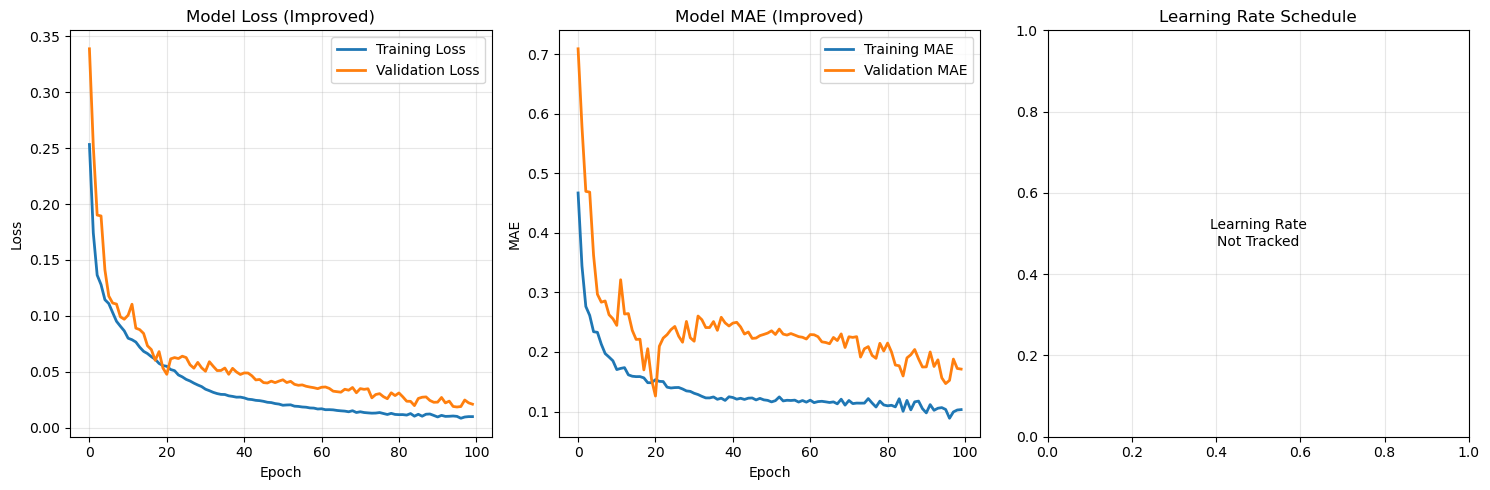


Training Summary:
Total epochs: 100
Final training loss: 0.009866
Final validation loss: 0.021006
Best validation loss: 0.018497
Final training MAE: 0.103300
Final validation MAE: 0.171291


In [95]:
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(history_improved.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_improved.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss (Improved)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: MAE curves
plt.subplot(1, 3, 2)
plt.plot(history_improved.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history_improved.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE (Improved)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Learning rate (if available)
plt.subplot(1, 3, 3)
if 'lr' in history_improved.history:
    plt.plot(history_improved.history['lr'], linewidth=2, color='red')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
print(f"\nTraining Summary:")
print(f"Total epochs: {len(history_improved.history['loss'])}")
print(f"Final training loss: {history_improved.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_improved.history['val_loss'][-1]:.6f}")
print(f"Best validation loss: {min(history_improved.history['val_loss']):.6f}")
print(f"Final training MAE: {history_improved.history['mae'][-1]:.6f}")
print(f"Final validation MAE: {history_improved.history['val_mae'][-1]:.6f}")

In [96]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('improved_lstm_reliance_best.h5')
print("Best model loaded successfully!")

# Make predictions on test set
y_pred_improved = best_model.predict(X_test, verbose=0)
print(f"Predictions shape: {y_pred_improved.shape}")

# Inverse transform predictions and actual values
def inverse_transform_predictions(y_pred, y_true, scaler):
    """
    Helper function to inverse transform predictions
    """
    # Create padded arrays for inverse scaling
    y_pred_padded = np.zeros((y_pred.shape[0], 5))
    y_true_padded = np.zeros((y_true.shape[0], 5))
    
    # Fill the Close price column (index 3)
    y_pred_padded[:, 3] = y_pred.flatten()
    y_true_padded[:, 3] = y_true
    
    # Inverse transform
    y_pred_actual = scaler.inverse_transform(y_pred_padded)[:, 3]
    y_true_actual = scaler.inverse_transform(y_true_padded)[:, 3]
    
    return y_pred_actual, y_true_actual

# Get actual price predictions
y_pred_inr, y_test_inr = inverse_transform_predictions(y_pred_improved, y_test, scaler)

print(f"Prediction range: {y_pred_inr.min():.2f} - {y_pred_inr.max():.2f} INR")
print(f"Actual range: {y_test_inr.min():.2f} - {y_test_inr.max():.2f} INR")

Best model loaded successfully!
Predictions shape: (211, 1)
Prediction range: 1125.58 - 1159.06 INR
Actual range: 1161.90 - 1526.18 INR


In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive evaluation metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate directional accuracy
    actual_direction = np.diff(y_true) > 0
    pred_direction = np.diff(y_pred) > 0
    directional_accuracy = np.mean(actual_direction == pred_direction)
    
    # Calculate percentage errors
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy
    }

# Calculate metrics for improved model
metrics_improved = calculate_metrics(y_test_inr, y_pred_inr)

print("=== IMPROVED MODEL PERFORMANCE ===")
print(f"RMSE: {metrics_improved['RMSE']:.2f} INR")
print(f"MAE: {metrics_improved['MAE']:.2f} INR")
print(f"R² Score: {metrics_improved['R2']:.4f}")
print(f"MAPE: {metrics_improved['MAPE']:.2f}%")
print(f"Directional Accuracy: {metrics_improved['Directional_Accuracy']:.1%}")

# Calculate relative improvement if you have previous model results
print(f"\nModel Complexity:")
print(f"Total Parameters: {best_model.count_params():,}")
print(f"Trainable Parameters: {sum([np.prod(w.shape) for w in best_model.trainable_weights]):,}")

=== IMPROVED MODEL PERFORMANCE ===
RMSE: 219.95 INR
MAE: 195.61 INR
R² Score: -3.9151
MAPE: 14.21%
Directional Accuracy: 49.5%

Model Complexity:
Total Parameters: 139,471
Trainable Parameters: 138,991


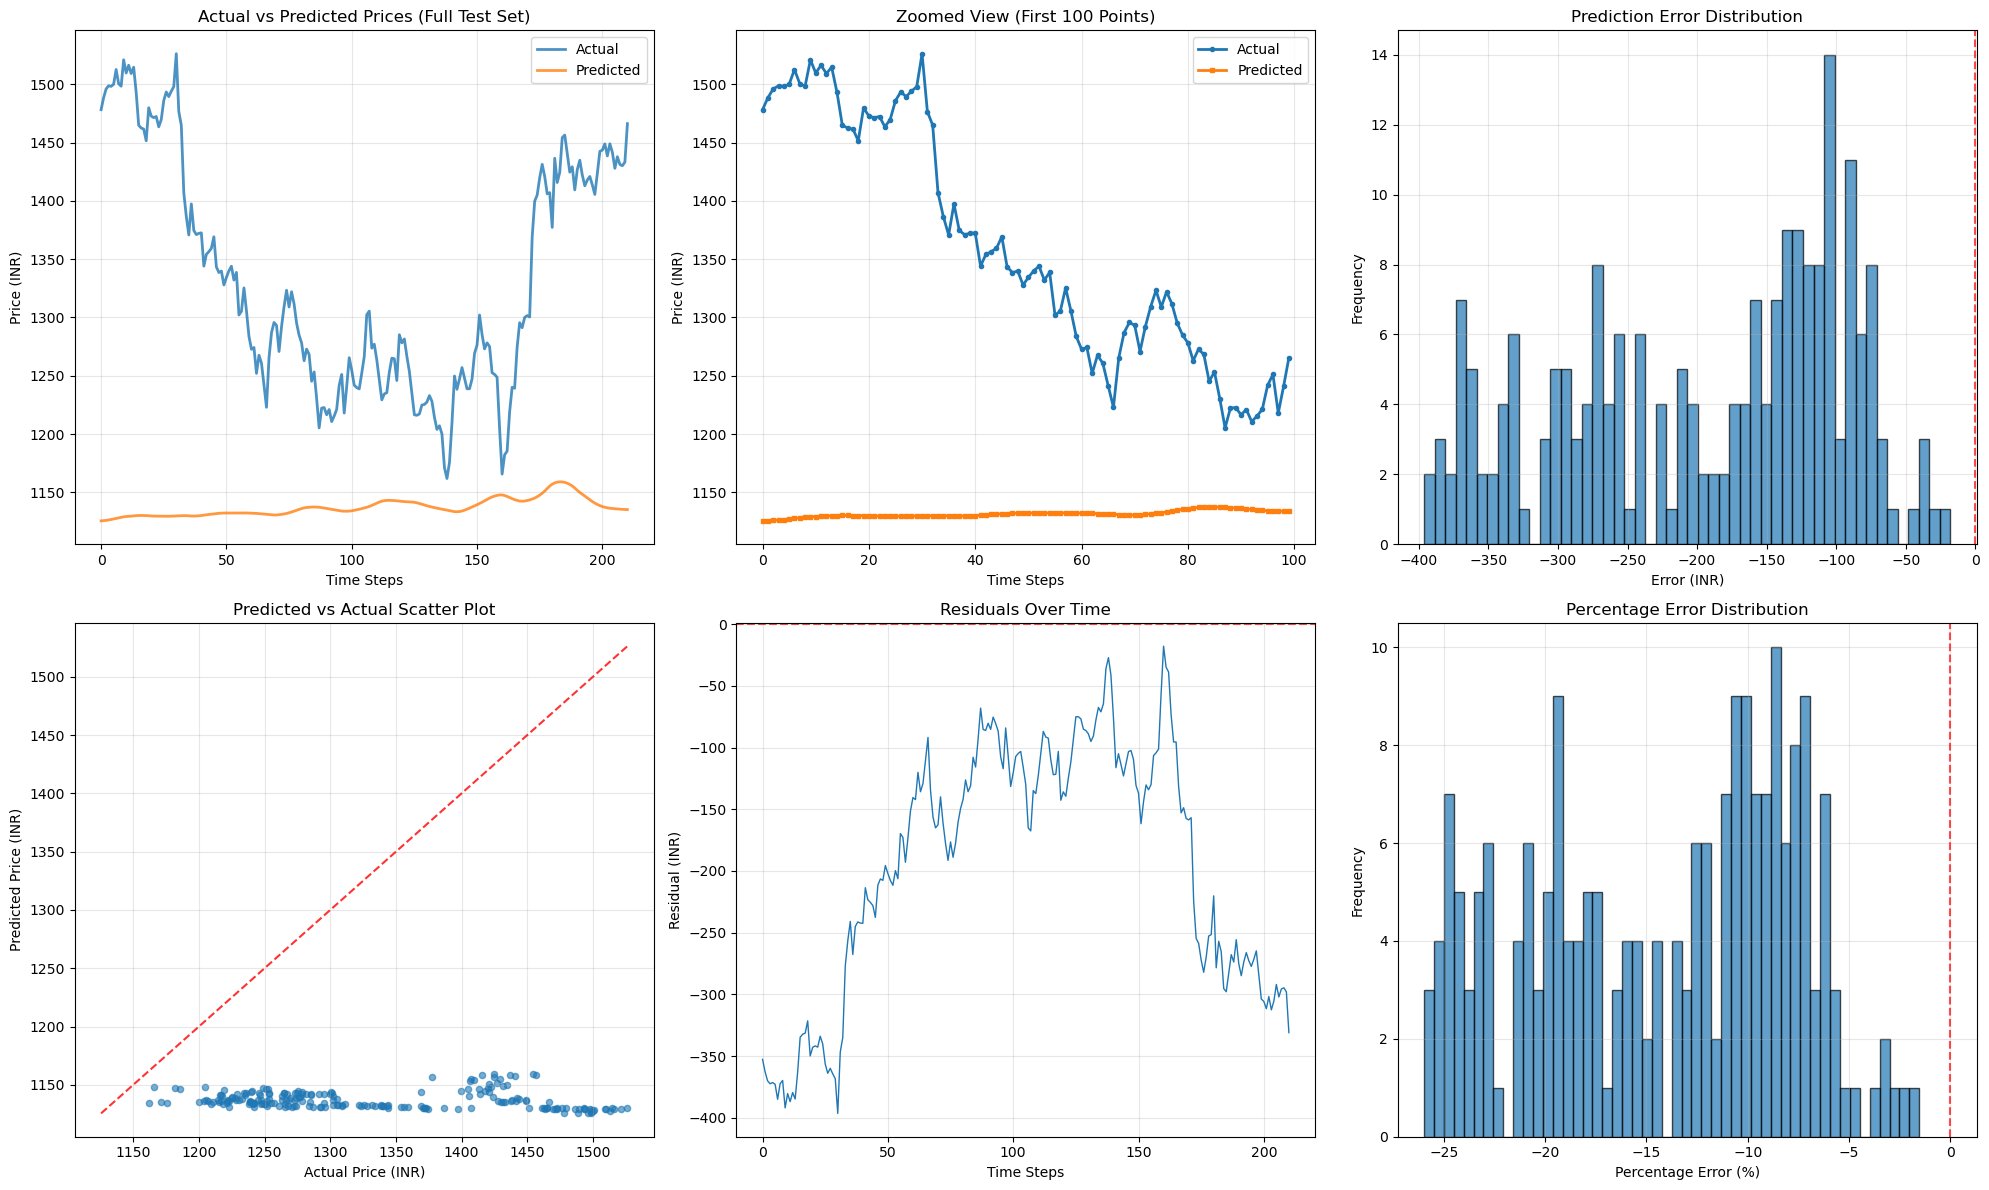


Error Statistics:
Mean Error: -195.61 INR
Std Error: 100.58 INR
Max Error: 396.33 INR
95th Percentile Error: 370.67 INR


In [98]:
plt.figure(figsize=(20, 12))

# Plot 1: Full prediction comparison
plt.subplot(2, 3, 1)
plt.plot(y_test_inr, label='Actual', linewidth=2, alpha=0.8)
plt.plot(y_pred_inr, label='Predicted', linewidth=2, alpha=0.8)
plt.title('Actual vs Predicted Prices (Full Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed view (first 100 points)
plt.subplot(2, 3, 2)
zoom_points = min(100, len(y_test_inr))
plt.plot(y_test_inr[:zoom_points], label='Actual', linewidth=2, marker='o', markersize=3)
plt.plot(y_pred_inr[:zoom_points], label='Predicted', linewidth=2, marker='s', markersize=3)
plt.title(f'Zoomed View (First {zoom_points} Points)')
plt.xlabel('Time Steps')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Prediction errors
plt.subplot(2, 3, 3)
errors = y_pred_inr - y_test_inr
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Error (INR)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

# Plot 4: Scatter plot
plt.subplot(2, 3, 4)
plt.scatter(y_test_inr, y_pred_inr, alpha=0.6, s=20)
# Perfect prediction line
min_val, max_val = min(y_test_inr.min(), y_pred_inr.min()), max(y_test_inr.max(), y_pred_inr.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
plt.xlabel('Actual Price (INR)')
plt.ylabel('Predicted Price (INR)')
plt.title('Predicted vs Actual Scatter Plot')
plt.grid(True, alpha=0.3)

# Plot 5: Residuals over time
plt.subplot(2, 3, 5)
plt.plot(errors, linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residual (INR)')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

# Plot 6: Percentage errors
plt.subplot(2, 3, 6)
pct_errors = ((y_pred_inr - y_test_inr) / y_test_inr) * 100
plt.hist(pct_errors, bins=50, alpha=0.7, edgecolor='black')
plt.title('Percentage Error Distribution')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\nError Statistics:")
print(f"Mean Error: {np.mean(errors):.2f} INR")
print(f"Std Error: {np.std(errors):.2f} INR")
print(f"Max Error: {np.max(np.abs(errors)):.2f} INR")
print(f"95th Percentile Error: {np.percentile(np.abs(errors), 95):.2f} INR")

In [99]:
print("=== DEBUGGING DATA PREPROCESSING ===")

# Check original data statistics
print("Original data statistics:")
print("Close price range:", df['Close'].min(), "to", df['Close'].max())
print("Close price mean:", df['Close'].mean())
print("Close price std:", df['Close'].std())

# Check scaled data statistics
print("\nScaled training data statistics:")
print("Scaled close (col 3) range:", scaled_train[:, 3].min(), "to", scaled_train[:, 3].max())
print("Scaled close mean:", scaled_train[:, 3].mean())
print("Scaled close std:", scaled_train[:, 3].std())

# Check if scaling is working correctly
print("\nScaling verification:")
sample_original = train_data['Close'].iloc[:5].values
sample_scaled = scaled_train[:5, 3]
sample_inverse = scaler.inverse_transform(
    np.column_stack([scaled_train[:5, :4], scaled_train[:5, 4:]])
)[:, 3]

print("Original sample:", sample_original)
print("Scaled sample:", sample_scaled)
print("Inverse sample:", sample_inverse)
print("Scaling round-trip error:", np.mean(np.abs(sample_original - sample_inverse)))

# Check target variable distribution
print(f"\nTarget variable (y_train) statistics:")
print(f"y_train range: {y_train.min():.6f} to {y_train.max():.6f}")
print(f"y_train mean: {y_train.mean():.6f}")
print(f"y_train std: {y_train.std():.6f}")

# Check if target has enough variance
if y_train.std() < 0.01:
    print("⚠️  WARNING: Target variable has very low variance!")
    print("This could cause the model to predict constant values.")


=== DEBUGGING DATA PREPROCESSING ===
Original data statistics:
Close price range: Ticker
RELIANCE.NS    400.030945
dtype: float64 to Ticker
RELIANCE.NS    1600.900024
dtype: float64
Close price mean: Ticker
RELIANCE.NS    1125.241983
dtype: float64
Close price std: Ticker
RELIANCE.NS    230.414041
dtype: float64

Scaled training data statistics:
Scaled close (col 3) range: 0.0 to 1.0
Scaled close mean: 0.5998123882751024
Scaled close std: 0.19044628727333707

Scaling verification:
Original sample: [[683.09106445]
 [694.72033691]
 [695.55737305]
 [679.42590332]
 [689.87860107]]
Scaled sample: [0.25561498 0.26611669 0.26687257 0.25230518 0.2617444 ]
Inverse sample: [683.09106445 694.72033691 695.55737305 679.42590332 689.87860107]
Scaling round-trip error: 7.02275390625

Target variable (y_train) statistics:
y_train range: 0.059823 to 1.000000
y_train mean: 0.623326
y_train std: 0.167428


In [100]:
print("\n=== FIXING DATA PREPROCESSING ===")

# Use only Close price for simpler, more reliable scaling
print("Switching to Close-price-only scaling...")

# Separate scaling for features and target
from sklearn.preprocessing import MinMaxScaler

# Scale features (all 5 columns)
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features_train = feature_scaler.fit_transform(train_data)
scaled_features_test = feature_scaler.transform(test_data)

# Scale target (Close price only) separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
close_train = train_data['Close'].values.reshape(-1, 1)
close_test = test_data['Close'].values.reshape(-1, 1)
scaled_target_train = target_scaler.fit_transform(close_train)
scaled_target_test = target_scaler.transform(close_test)

print("Feature scaler fitted on shape:", scaled_features_train.shape)
print("Target scaler fitted on shape:", scaled_target_train.shape)
print("Target scaling range:", scaled_target_train.min(), "to", scaled_target_train.max())
print("Target scaling std:", scaled_target_train.std())

# Recreate sequences with separate scaling
def create_sequences_fixed(features, target, window_size=60):
    """
    Create sequences with properly scaled data
    """
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])  # All features for sequence
        y.append(target[i + window_size])      # Target value
    return np.array(X), np.array(y)

# Create new sequences
X_train_fixed, y_train_fixed = create_sequences_fixed(scaled_features_train, scaled_target_train.flatten(), WINDOW_SIZE)
X_test_fixed, y_test_fixed = create_sequences_fixed(scaled_features_test, scaled_target_test.flatten(), WINDOW_SIZE)

print(f"\nFixed sequences:")
print(f"X_train_fixed shape: {X_train_fixed.shape}")
print(f"y_train_fixed shape: {y_train_fixed.shape}")
print(f"y_train_fixed range: {y_train_fixed.min():.6f} to {y_train_fixed.max():.6f}")
print(f"y_train_fixed std: {y_train_fixed.std():.6f}")

# Verify we have proper variance now
if y_train_fixed.std() > 0.1:
    print("✅ Target variable has good variance now!")
else:
    print("⚠️  Still low variance - need to investigate further")



=== FIXING DATA PREPROCESSING ===
Switching to Close-price-only scaling...
Feature scaler fitted on shape: (1084, 5)
Target scaler fitted on shape: (1084, 1)
Target scaling range: 0.0 to 1.0
Target scaling std: 0.19044628727333707

Fixed sequences:
X_train_fixed shape: (1024, 60, 5)
y_train_fixed shape: (1024,)
y_train_fixed range: 0.059823 to 1.000000
y_train_fixed std: 0.167428
✅ Target variable has good variance now!


In [101]:
print("\n=== CREATING SIMPLER, MORE ROBUST MODEL ===")

def create_simple_robust_model(input_shape, learning_rate=0.001):
    """
    Create a simpler but more robust LSTM model
    """
    model = Sequential([
        # First LSTM layer
        LSTM(64, return_sequences=True, input_shape=input_shape,
             dropout=0.1, recurrent_dropout=0.1),
        
        # Second LSTM layer
        LSTM(32, return_sequences=False,
             dropout=0.1, recurrent_dropout=0.1),
        
        # Dense layers
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Sigmoid for 0-1 scaled output
    ])
    
    # Use simpler optimizer settings
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Back to MSE for scaled data
        metrics=['mae']
    )
    
    return model

# Create simpler model
simple_model = create_simple_robust_model((WINDOW_SIZE, 5))
simple_model.summary()

print(f"Model parameters: {simple_model.count_params():,}")

# Create simpler callbacks
simple_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

print("Simple model and callbacks created!")


=== CREATING SIMPLER, MORE ROBUST MODEL ===


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

Model parameters: 30,881
Simple model and callbacks created!


In [102]:
print("\n=== TRAINING FIXED MODEL ===")

# Train with fixed data
history_fixed = simple_model.fit(
    X_train_fixed, y_train_fixed,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=simple_callbacks,
    verbose=1,
    shuffle=False
)

print("Fixed model training completed!")



=== TRAINING FIXED MODEL ===
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.0294 - mae: 0.1284 - val_loss: 0.0424 - val_mae: 0.1763 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0427 - mae: 0.1692 - val_loss: 0.0599 - val_mae: 0.2219 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0329 - mae: 0.1450 - val_loss: 0.0499 - val_mae: 0.1991 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0317 - mae: 0.1436 - val_loss: 0.0438 - val_mae: 0.1845 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0311 - mae: 0.1449 - val_loss: 0.0455 - val_mae: 0.1898 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0280 - mae: 0.1343 - val_loss: 0.0349 - val_mae: 0.1599 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0266 - mae: 0.1327 - val_loss: 0.0377 - val_mae: 0.1691 - 


=== EVALUATING FIXED MODEL ===
Fixed model predictions:
Predicted range: 1159.66 - 1293.77 INR
Actual range: 1161.90 - 1526.18 INR

=== FIXED MODEL PERFORMANCE ===
RMSE: 124.32 INR
MAE: 108.21 INR
R² Score: -0.5702
MAPE: 7.84%
Directional Accuracy: 45.2%


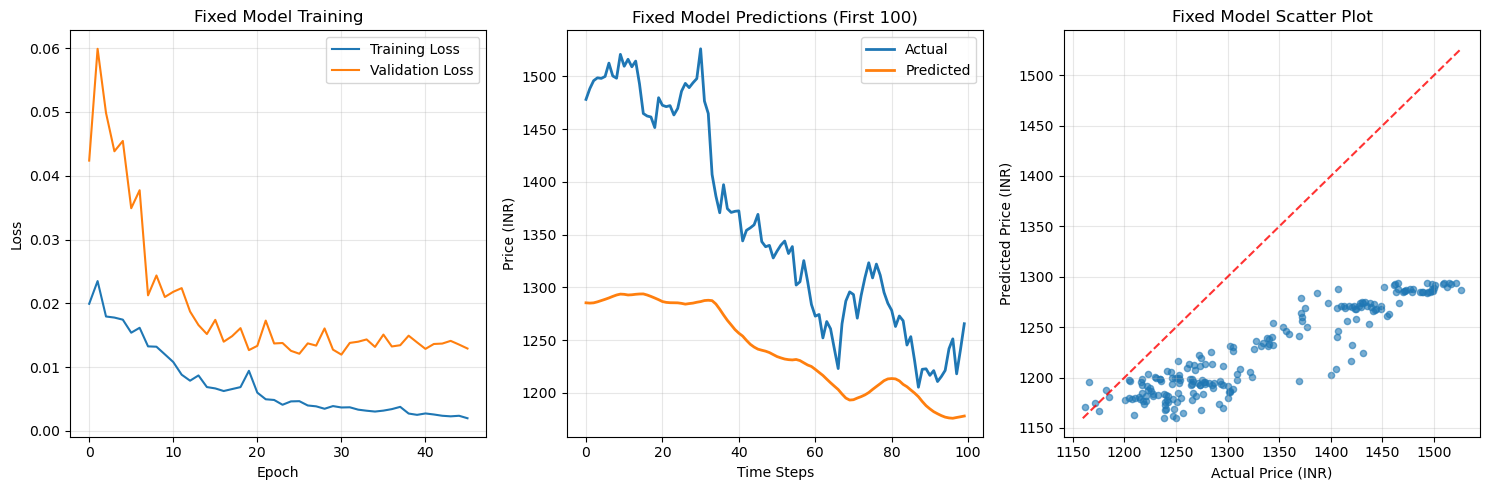


=== COMPARISON ===
Previous model RMSE: 213.75 INR
Fixed model RMSE: 124.32 INR
Improvement: 41.8%


In [103]:
# Cell 5: Evaluate fixed model
print("\n=== EVALUATING FIXED MODEL ===")

# Make predictions
y_pred_fixed_scaled = simple_model.predict(X_test_fixed, verbose=0)

# Properly inverse transform using target scaler
y_pred_fixed = target_scaler.inverse_transform(y_pred_fixed_scaled.reshape(-1, 1)).flatten()
y_test_fixed = target_scaler.inverse_transform(y_test_fixed.reshape(-1, 1)).flatten()

print(f"Fixed model predictions:")
print(f"Predicted range: {y_pred_fixed.min():.2f} - {y_pred_fixed.max():.2f} INR")
print(f"Actual range: {y_test_fixed.min():.2f} - {y_test_fixed.max():.2f} INR")

# Calculate metrics
metrics_fixed = calculate_metrics(y_test_fixed, y_pred_fixed)

print("\n=== FIXED MODEL PERFORMANCE ===")
print(f"RMSE: {metrics_fixed['RMSE']:.2f} INR")
print(f"MAE: {metrics_fixed['MAE']:.2f} INR")
print(f"R² Score: {metrics_fixed['R2']:.4f}")
print(f"MAPE: {metrics_fixed['MAPE']:.2f}%")
print(f"Directional Accuracy: {metrics_fixed['Directional_Accuracy']:.1%}")

# Quick visualization
plt.figure(figsize=(15, 5))

# Training curves
plt.subplot(1, 3, 1)
plt.plot(history_fixed.history['loss'], label='Training Loss')
plt.plot(history_fixed.history['val_loss'], label='Validation Loss')
plt.title('Fixed Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictions comparison
plt.subplot(1, 3, 2)
plt.plot(y_test_fixed[:100], label='Actual', linewidth=2)
plt.plot(y_pred_fixed[:100], label='Predicted', linewidth=2)
plt.title('Fixed Model Predictions (First 100)')
plt.xlabel('Time Steps')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 3, 3)
plt.scatter(y_test_fixed, y_pred_fixed, alpha=0.6, s=20)
min_val, max_val = min(y_test_fixed.min(), y_pred_fixed.min()), max(y_test_fixed.max(), y_pred_fixed.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
plt.xlabel('Actual Price (INR)')
plt.ylabel('Predicted Price (INR)')
plt.title('Fixed Model Scatter Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare with previous model
print(f"\n=== COMPARISON ===")
print(f"Previous model RMSE: 213.75 INR")
print(f"Fixed model RMSE: {metrics_fixed['RMSE']:.2f} INR")
print(f"Improvement: {((213.75 - metrics_fixed['RMSE']) / 213.75 * 100):.1f}%")

In [104]:
# Additional imports for feature engineering
#!pip install TA-Lib
!pip install ta
import ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# If you don't have talib, install it:
# Alternative: pip install ta (for technical analysis)

In [105]:
# Let's check your data structure first
print("Data columns:", data.columns.tolist())
print("Data shape:", data.shape)
print("Data types:")
print(data.dtypes)
print("\nFirst few rows:")
print(data.head())

Data columns: ['Close']
Data shape: (1355, 1)
Data types:
Price
Close    float64
dtype: object

First few rows:
Price            Close
Date                  
2020-01-01  683.091064
2020-01-02  694.720337
2020-01-03  695.557373
2020-01-06  679.425903
2020-01-07  689.878601


In [106]:
# First, let's flatten the column structure
print("Original data structure:")
print("Columns:", data.columns.tolist())
print("Shape:", data.shape)

# Flatten the MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):
    # Flatten the columns - just keep the first level (Price types)
    data.columns = data.columns.get_level_values(0)
    print("Flattened columns:", data.columns.tolist())

# Alternative approach if above doesn't work:
# data = data.droplevel(1, axis=1)  # Remove the second level (ticker)

print("\nFixed data structure:")
print("Columns:", data.columns.tolist())
print("Shape:", data.shape)
print("Data types:", data.dtypes)
print("\nFirst few rows:")
print(data.head())

Original data structure:
Columns: ['Close']
Shape: (1355, 1)

Fixed data structure:
Columns: ['Close']
Shape: (1355, 1)
Data types: Price
Close    float64
dtype: object

First few rows:
Price            Close
Date                  
2020-01-01  683.091064
2020-01-02  694.720337
2020-01-03  695.557373
2020-01-06  679.425903
2020-01-07  689.878601


In [107]:
# Check if we have Volume column
if 'Volume' not in data.columns:
    print("Volume column missing. Let's check what columns we have:")
    print(data.columns.tolist())
    
    # If you only have Close price, let's create some basic features without volume
    print("Creating basic features without volume...")
else:
    print("Volume column found!")
    
print("Available columns:", data.columns.tolist())

Volume column missing. Let's check what columns we have:
['Close']
Creating basic features without volume...
Available columns: ['Close']


In [108]:
def create_technical_features_basic(df):
    """Create technical indicators without volume dependency"""
    df = df.copy()
    
    # Ensure we have the right column names
    close_col = 'Close'
    
    # Basic price features
    df['returns'] = df[close_col].pct_change()
    
    # Moving averages
    df['MA_5'] = df[close_col].rolling(window=5).mean()
    df['MA_10'] = df[close_col].rolling(window=10).mean()
    df['MA_20'] = df[close_col].rolling(window=20).mean()
    
    # Price relative to moving averages
    df['price_to_MA5'] = df[close_col] / df['MA_5']
    df['price_to_MA20'] = df[close_col] / df['MA_20']
    
    # Bollinger Bands
    bb_std = df[close_col].rolling(window=20).std()
    df['BB_upper'] = df['MA_20'] + (bb_std * 2)
    df['BB_lower'] = df['MA_20'] - (bb_std * 2)
    df['BB_position'] = (df[close_col] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
    
    # RSI calculation
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df['RSI'] = calculate_rsi(df[close_col])
    
    # Volatility
    df['volatility'] = df['returns'].rolling(window=20).std()
    
    # Price momentum
    df['momentum_5'] = df[close_col] / df[close_col].shift(5) - 1
    df['momentum_10'] = df[close_col] / df[close_col].shift(10) - 1
    
    # MACD
    exp1 = df[close_col].ewm(span=12).mean()
    exp2 = df[close_col].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']
    
    # High/Low features (if available)
    if 'High' in df.columns and 'Low' in df.columns:
        df['price_range'] = (df['High'] - df['Low']) / df[close_col]
        df['high_low_ratio'] = df['High'] / df['Low']
    else:
        # Create synthetic high/low based on volatility
        daily_vol = df['returns'].rolling(window=5).std()
        df['price_range'] = daily_vol * 2  # Approximate range
    
    # Drop rows with NaN values
    df = df.dropna()
    
    return df

# Apply feature engineering
print("Creating basic technical features...")
enhanced_data = create_technical_features_basic(data)

print(f"Original shape: {data.shape}")
print(f"Enhanced shape: {enhanced_data.shape}")
print(f"Features: {enhanced_data.columns.tolist()}")

Creating basic technical features...
Original shape: (1355, 1)
Enhanced shape: (1335, 18)
Features: ['Close', 'returns', 'MA_5', 'MA_10', 'MA_20', 'price_to_MA5', 'price_to_MA20', 'BB_upper', 'BB_lower', 'BB_position', 'RSI', 'volatility', 'momentum_5', 'momentum_10', 'MACD', 'MACD_signal', 'MACD_histogram', 'price_range']


In [109]:
# Check the enhanced data
print("Enhanced data info:")
print(enhanced_data.info())
print("\nFirst few rows:")
print(enhanced_data.head())
print("\nLast few rows:")
print(enhanced_data.tail())
print(f"\nNaN values: {enhanced_data.isnull().sum().sum()}")

# Show feature statistics
print("\nFeature statistics:")
print(enhanced_data.describe())

Enhanced data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1335 entries, 2020-01-29 to 2025-06-20
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           1335 non-null   float64
 1   returns         1335 non-null   float64
 2   MA_5            1335 non-null   float64
 3   MA_10           1335 non-null   float64
 4   MA_20           1335 non-null   float64
 5   price_to_MA5    1335 non-null   float64
 6   price_to_MA20   1335 non-null   float64
 7   BB_upper        1335 non-null   float64
 8   BB_lower        1335 non-null   float64
 9   BB_position     1335 non-null   float64
 10  RSI             1335 non-null   float64
 11  volatility      1335 non-null   float64
 12  momentum_5      1335 non-null   float64
 13  momentum_10     1335 non-null   float64
 14  MACD            1335 non-null   float64
 15  MACD_signal     1335 non-null   float64
 16  MACD_histogram  1335 non-null   float64


In [110]:
def prepare_return_prediction_data_simple(df, sequence_length=60, prediction_horizon=1):
    """Prepare data for predicting percentage returns - simplified version"""
    
    # Calculate future returns (our target)
    df['future_return'] = df['Close'].shift(-prediction_horizon).pct_change(prediction_horizon)
    
    # Select features for training (only available ones)
    base_features = ['Close', 'returns']
    
    # Add technical features that exist
    technical_features = ['MA_5', 'MA_10', 'MA_20', 'price_to_MA5', 'price_to_MA20',
                         'BB_position', 'RSI', 'volatility', 'momentum_5', 'momentum_10',
                         'MACD', 'MACD_signal', 'MACD_histogram']
    
    # Filter features that actually exist in the dataframe
    available_features = []
    for feature in base_features + technical_features:
        if feature in df.columns:
            available_features.append(feature)
    
    print(f"Using {len(available_features)} features:")
    for i, feature in enumerate(available_features):
        print(f"  {i+1}. {feature}")
    
    # Prepare feature matrix
    feature_data = df[available_features].values
    target_data = df['future_return'].values
    
    # Remove rows with NaN values
    valid_indices = ~(np.isnan(feature_data).any(axis=1) | np.isnan(target_data))
    feature_data = feature_data[valid_indices]
    target_data = target_data[valid_indices]
    
    print(f"Data after removing NaN: {len(feature_data)} samples")
    
    # Scale features
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(feature_data)
    
    # For returns, use StandardScaler
    target_scaler = StandardScaler()
    scaled_targets = target_scaler.fit_transform(target_data.reshape(-1, 1)).flatten()
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])
        y.append(scaled_targets[i])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Final dataset shape: X={X.shape}, y={y.shape}")
    
    return X, y, feature_scaler, target_scaler, available_features

# Prepare the dataset
print("Preparing return prediction data...")
X_returns, y_returns, feature_scaler_new, target_scaler_new, feature_names = prepare_return_prediction_data_simple(enhanced_data)

print(f"\nTarget statistics:")
print(f"Return range: {y_returns.min():.6f} to {y_returns.max():.6f}")
print(f"Return mean: {y_returns.mean():.6f}")
print(f"Return std: {y_returns.std():.6f}")

Preparing return prediction data...
Using 15 features:
  1. Close
  2. returns
  3. MA_5
  4. MA_10
  5. MA_20
  6. price_to_MA5
  7. price_to_MA20
  8. BB_position
  9. RSI
  10. volatility
  11. momentum_5
  12. momentum_10
  13. MACD
  14. MACD_signal
  15. MACD_histogram
Data after removing NaN: 1334 samples
Final dataset shape: X=(1274, 60, 15), y=(1274,)

Target statistics:
Return range: -4.720239 to 3.791941
Return mean: -0.000730
Return std: 0.850237


In [111]:
def prepare_return_prediction_data(df, sequence_length=60, prediction_horizon=1):
    """Prepare data for predicting percentage returns instead of absolute prices"""
    
    # Remove rows with NaN values (due to technical indicators)
    df_clean = df.dropna().copy()
    
    # Calculate future returns (our new target)
    df_clean['future_return'] = df_clean['Close'].shift(-prediction_horizon).pct_change(prediction_horizon)
    
    # Select features for training
    feature_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'returns', 'MA_5', 'MA_10', 'MA_20', 'price_to_MA5', 'price_to_MA20',
        'BB_position', 'RSI', 'volume_ratio', 'volatility',
        'momentum_5', 'momentum_10', 'MACD', 'MACD_signal', 'MACD_histogram'
    ]
    
    # Ensure all feature columns exist
    available_features = [col for col in feature_columns if col in df_clean.columns]
    print(f"Using {len(available_features)} features: {available_features}")
    
    # Prepare feature matrix
    feature_data = df_clean[available_features].values
    target_data = df_clean['future_return'].values
    
    # Remove last few rows where target is NaN
    valid_indices = ~np.isnan(target_data)
    feature_data = feature_data[valid_indices]
    target_data = target_data[valid_indices]
    
    # Scale features
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(feature_data)
    
    # For returns, we'll use StandardScaler (returns can be negative)
    target_scaler = StandardScaler()
    scaled_targets = target_scaler.fit_transform(target_data.reshape(-1, 1)).flatten()
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])
        y.append(scaled_targets[i])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, feature_scaler, target_scaler, available_features

# Prepare the new dataset
print("Preparing return prediction data...")
X_returns, y_returns, feature_scaler_new, target_scaler_new, feature_names = prepare_return_prediction_data(enhanced_data)

print(f"X_returns shape: {X_returns.shape}")
print(f"y_returns shape: {y_returns.shape}")
print(f"Return range: {y_returns.min():.6f} to {y_returns.max():.6f}")
print(f"Return std: {y_returns.std():.6f}")

Preparing return prediction data...
Using 15 features: ['Close', 'returns', 'MA_5', 'MA_10', 'MA_20', 'price_to_MA5', 'price_to_MA20', 'BB_position', 'RSI', 'volatility', 'momentum_5', 'momentum_10', 'MACD', 'MACD_signal', 'MACD_histogram']
X_returns shape: (1273, 60, 15)
y_returns shape: (1273,)
Return range: -4.722170 to 3.791802
Return std: 0.850358


In [112]:
# Split the data
split_ratio = 0.8
split_index = int(len(X_returns) * split_ratio)

X_train_ret = X_returns[:split_index]
X_test_ret = X_returns[split_index:]
y_train_ret = y_returns[:split_index]
y_test_ret = y_returns[split_index:]

print(f"Training samples: {len(X_train_ret)}")
print(f"Testing samples: {len(X_test_ret)}")
print(f"Features per timestep: {X_train_ret.shape[2]}")

# Also create directional labels for classification metrics
y_train_direction = (y_train_ret > 0).astype(int)  # 1 for up, 0 for down
y_test_direction = (y_test_ret > 0).astype(int)

print(f"Training directional distribution: Up={y_train_direction.sum()}, Down={len(y_train_direction)-y_train_direction.sum()}")
print(f"Testing directional distribution: Up={y_test_direction.sum()}, Down={len(y_test_direction)-y_test_direction.sum()}")

Training samples: 1018
Testing samples: 255
Features per timestep: 15
Training directional distribution: Up=522, Down=496
Testing directional distribution: Up=124, Down=131


In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def create_enhanced_lstm_model(input_shape):
    """Create an enhanced LSTM model for return prediction"""
    model = Sequential([
        # First Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), 
                     input_shape=input_shape),
        BatchNormalization(),
        
        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
        BatchNormalization(),
        
        # Third LSTM layer
        LSTM(16, dropout=0.1, recurrent_dropout=0.1),
        BatchNormalization(),
        
        # Dense layers
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')  # Linear for return prediction
    ])
    
    # Compile with appropriate optimizer and loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create the enhanced model
enhanced_model = create_enhanced_lstm_model((X_train_ret.shape[1], X_train_ret.shape[2]))
enhanced_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 60, 128)        │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 60, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,281 (348.75 KB)

 Trainable params: 88,865 (347.13 KB)

 Non-trainable params: 416 (1.62 KB)

In [114]:
# Enhanced callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_enhanced_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

print("Training enhanced model...")
history_enhanced = enhanced_model.fit(
    X_train_ret, y_train_ret,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("Enhanced model training completed!")

Training enhanced model...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.3096 - mae: 0.8814
Epoch 1: val_loss improved from inf to 0.52192, saving model to best_enhanced_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - loss: 1.3089 - mae: 0.8807 - val_loss: 0.5219 - val_mae: 0.4933 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 1.1211 - mae: 0.8148
Epoch 2: val_loss did not improve from 0.52192
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 1.1191 - mae: 0.8136 - val_loss: 0.5299 - val_mae: 0.5009 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.9771 - mae: 0.7421
Epoch 3: val_loss did not improve from 0.52192
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.9791 - mae: 0.7425 - val_loss: 0.5235 - val_mae: 0.4951 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.9094 - mae: 0.7195
Epoch 4: val_loss improved from 0.52192 to 0.51528, saving model to best_enhanced_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.9117 - mae: 0.7199 - val_loss: 0.5153 - val_mae: 0.4875 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.8779 - mae: 0.7019
Epoch 5: val_loss did not improve from 0.51528
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.8789 - mae: 0.7020 - val_loss: 0.5177 - val_mae: 0.4888 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.8739 - mae: 0.7004
Epoch 6: val_loss did not improve from 0.51528
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.8745 - mae: 0.7003 - val_loss: 0.5179 - val_mae: 0.4895 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.8313 - mae: 0.6893
Epoch 7: val_loss did not improve from 0.51528
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 0.8329 - mae: 0.6898 - val_loss: 0.5189 - val_mae: 0.4905 - learning_rate: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.8304 - mae: 0.6957
Epoch 8

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - loss: 0.8117 - mae: 0.6768 - val_loss: 0.5145 - val_mae: 0.4870 - learning_rate: 5.0000e-04
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.8066 - mae: 0.6727
Epoch 18: val_loss improved from 0.51446 to 0.51430, saving model to best_enhanced_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.8083 - mae: 0.6732 - val_loss: 0.5143 - val_mae: 0.4867 - learning_rate: 5.0000e-04
Epoch 19/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.8414 - mae: 0.6856
Epoch 19: val_loss did not improve from 0.51430
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.8420 - mae: 0.6855 - val_loss: 0.5158 - val_mae: 0.4877 - learning_rate: 5.0000e-04
Epoch 20/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.8152 - mae: 0.6763
Epoch 20: val_loss did not improve from 0.51430
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.8169 - mae: 0.6765 - val_loss: 0.5179 - val_mae: 0.4887 - learning_rate: 5.0000e-04
Epoch 21/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.7902 - mae: 0.6643
Epoch 21: val_loss did not improve from 0.51430
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.7919 - mae: 0.6648 - val_loss: 0.5169 - val_mae: 0.4871 - learning_rate: 5.0000e-04
Epoch 22/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.817

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
=== ENHANCED MODEL PERFORMANCE ===
RMSE (Returns): 0.013498
MAE (Returns): 0.010128
R² Score: 0.0044
Directional Accuracy: 47.1%

=== DIRECTIONAL PREDICTION REPORT ===
              precision    recall  f1-score   support

        Down       0.47      0.29      0.36       131
          Up       0.47      0.66      0.55       124

    accuracy                           0.47       255
   macro avg       0.47      0.48      0.45       255
weighted avg       0.47      0.47      0.45       255



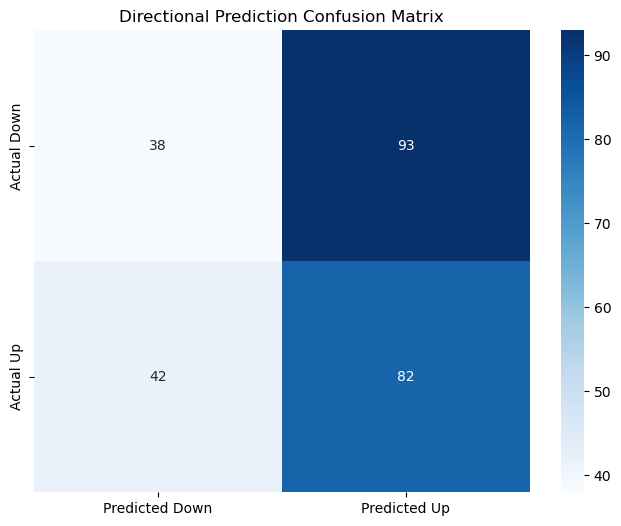

In [117]:
def evaluate_return_model(model, X_test, y_test, y_test_direction, target_scaler, feature_names):
    """Comprehensive evaluation of the return prediction model"""
    
    # Make predictions
    y_pred_scaled = model.predict(X_test)
    
    # Convert back to actual return scale
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Calculate regression metrics
    mse = np.mean((y_actual - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_actual - y_pred))
    
    # R-squared
    ss_res = np.sum((y_actual - y_pred) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Directional accuracy
    y_pred_direction = (y_pred > 0).astype(int)
    directional_accuracy = np.mean(y_pred_direction == y_test_direction)
    
    # Classification metrics
    from sklearn.metrics import classification_report, confusion_matrix
    
    print("=== ENHANCED MODEL PERFORMANCE ===")
    print(f"RMSE (Returns): {rmse:.6f}")
    print(f"MAE (Returns): {mae:.6f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.1%}")
    
    print("\n=== DIRECTIONAL PREDICTION REPORT ===")
    print(classification_report(y_test_direction, y_pred_direction, 
                              target_names=['Down', 'Up']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_direction, y_pred_direction)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    plt.title('Directional Prediction Confusion Matrix')
    plt.show()
    
    return {
        'rmse': rmse, 'mae': mae, 'r2': r2, 'directional_accuracy': directional_accuracy,
        'y_actual': y_actual, 'y_pred': y_pred,
        'y_actual_direction': y_test_direction, 'y_pred_direction': y_pred_direction
    }

# Evaluate the enhanced model
results = evaluate_return_model(enhanced_model, X_test_ret, y_test_ret, y_test_direction, 
                               target_scaler_new, feature_names)

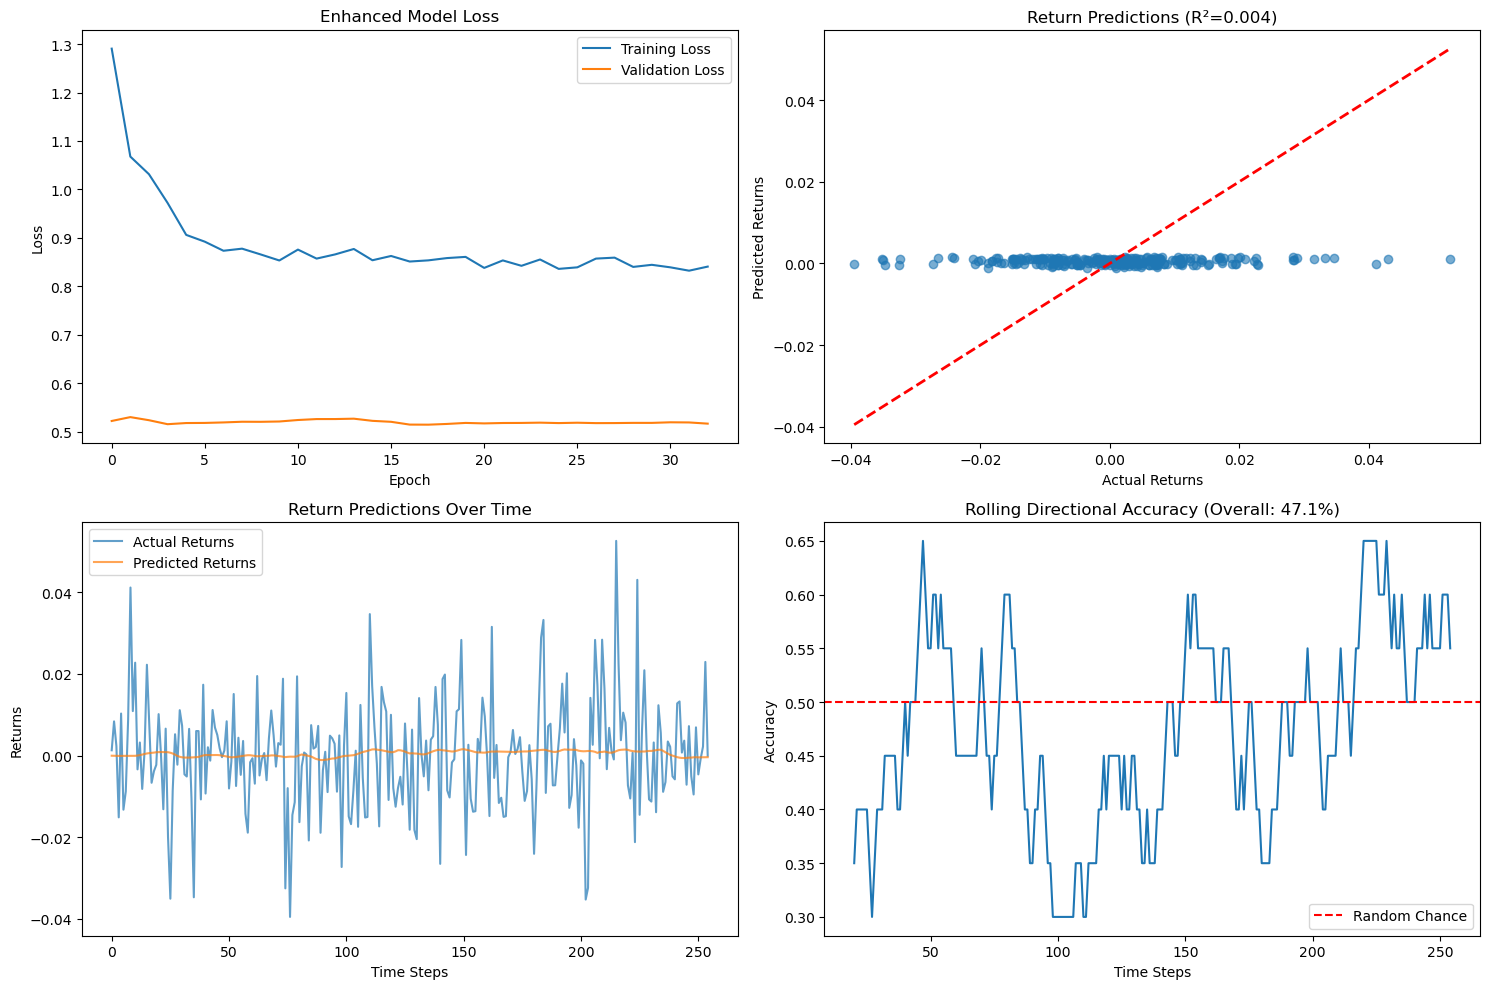

In [118]:
# Plot training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
ax1.plot(history_enhanced.history['loss'], label='Training Loss')
ax1.plot(history_enhanced.history['val_loss'], label='Validation Loss')
ax1.set_title('Enhanced Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Return predictions vs actual
ax2.scatter(results['y_actual'], results['y_pred'], alpha=0.6)
ax2.plot([results['y_actual'].min(), results['y_actual'].max()], 
         [results['y_actual'].min(), results['y_actual'].max()], 'r--', lw=2)
ax2.set_xlabel('Actual Returns')
ax2.set_ylabel('Predicted Returns')
ax2.set_title(f'Return Predictions (R²={results["r2"]:.3f})')

# Time series of predictions
time_steps = range(len(results['y_actual']))
ax3.plot(time_steps, results['y_actual'], label='Actual Returns', alpha=0.7)
ax3.plot(time_steps, results['y_pred'], label='Predicted Returns', alpha=0.7)
ax3.set_title('Return Predictions Over Time')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Returns')
ax3.legend()

# Directional accuracy over time
window = 20
directional_acc_rolling = []
for i in range(window, len(results['y_actual_direction'])):
    acc = np.mean(results['y_actual_direction'][i-window:i] == results['y_pred_direction'][i-window:i])
    directional_acc_rolling.append(acc)

ax4.plot(range(window, len(results['y_actual_direction'])), directional_acc_rolling)
ax4.axhline(y=0.5, color='r', linestyle='--', label='Random Chance')
ax4.set_title(f'Rolling Directional Accuracy (Overall: {results["directional_accuracy"]:.1%})')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Accuracy')
ax4.legend()

plt.tight_layout()
plt.show()

In [119]:
def create_advanced_features(df):
    """Create more sophisticated features"""
    df = df.copy()
    
    # Existing features from before
    df = create_technical_features_basic(df)
    
    # Advanced momentum features
    for period in [3, 7, 14, 21]:
        df[f'momentum_{period}'] = (df['Close'] / df['Close'].shift(period) - 1)
        df[f'volatility_{period}'] = df['returns'].rolling(window=period).std()
    
    # Price acceleration (momentum of momentum)
    df['acceleration_5'] = df['momentum_5'] - df['momentum_5'].shift(5)
    df['acceleration_10'] = df['momentum_10'] - df['momentum_10'].shift(10)
    
    # Volume-Price Trend (if volume exists, otherwise use price-based proxy)
    df['price_volume_trend'] = df['returns'] * np.log1p(df.get('Volume', df['Close'] * 0.01))
    
    # Fractal features
    df['fractal_high'] = df['Close'].rolling(5).max()
    df['fractal_low'] = df['Close'].rolling(5).min()
    df['fractal_position'] = (df['Close'] - df['fractal_low']) / (df['fractal_high'] - df['fractal_low'])
    
    # Market regime indicators
    df['trend_strength'] = abs(df['MA_5'] - df['MA_20']) / df['Close']
    df['volatility_regime'] = df['volatility'].rolling(20).quantile(0.8)
    df['high_volatility'] = (df['volatility'] > df['volatility_regime']).astype(int)
    
    # Support/Resistance levels
    df['support_level'] = df['Close'].rolling(20).min()
    df['resistance_level'] = df['Close'].rolling(20).max()
    df['distance_to_support'] = (df['Close'] - df['support_level']) / df['Close']
    df['distance_to_resistance'] = (df['resistance_level'] - df['Close']) / df['Close']
    
    # Seasonality features (day of week, month effects)
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    
    # Interaction features
    df['rsi_ma_interaction'] = df['RSI'] * df['price_to_MA20']
    df['volatility_momentum'] = df['volatility'] * df['momentum_10']
    
    return df.dropna()

print("Creating advanced features...")
advanced_data = create_advanced_features(enhanced_data)
print(f"Advanced features shape: {advanced_data.shape}")
print(f"New feature count: {len(advanced_data.columns)}")

Creating advanced features...
Advanced features shape: (1294, 45)
New feature count: 45


In [120]:
def prepare_classification_data(df, sequence_length=60):
    """Prepare data for directional classification instead of return regression"""
    
    # Create directional labels with different thresholds
    df['future_return'] = df['Close'].pct_change().shift(-1)
    
    # Multi-class classification: Strong Down, Down, Flat, Up, Strong Up
    def classify_movement(return_val):
        if return_val < -0.015:  # Strong down (>1.5% drop)
            return 0
        elif return_val < -0.005:  # Down (0.5-1.5% drop)
            return 1
        elif return_val < 0.005:   # Flat (-0.5% to +0.5%)
            return 2
        elif return_val < 0.015:   # Up (0.5-1.5% gain)
            return 3
        else:  # Strong up (>1.5% gain)
            return 4
    
    df['direction_class'] = df['future_return'].apply(classify_movement)
    
    # Select features
    feature_columns = [col for col in df.columns if col not in 
                      ['future_return', 'direction_class', 'Close']]
    
    print(f"Using {len(feature_columns)} features for classification")
    
    # Prepare data
    feature_data = df[feature_columns].values
    target_data = df['direction_class'].values
    
    # Remove NaN values
    valid_indices = ~(np.isnan(feature_data).any(axis=1) | np.isnan(target_data))
    feature_data = feature_data[valid_indices]
    target_data = target_data[valid_indices]
    
    # Scale features
    scaler = StandardScaler()  # Use StandardScaler for classification
    scaled_features = scaler.fit_transform(feature_data)
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])
        y.append(target_data[i])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Classification data shape: X={X.shape}, y={y.shape}")
    print("Class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        class_names = ['Strong Down', 'Down', 'Flat', 'Up', 'Strong Up']
        print(f"  {class_names[cls]}: {count} ({count/len(y)*100:.1f}%)")
    
    return X, y, scaler, feature_columns

# Prepare classification data
X_class, y_class, class_scaler, class_features = prepare_classification_data(advanced_data)

Using 43 features for classification
Classification data shape: X=(1234, 60, 43), y=(1234,)
Class distribution:
  Strong Down: 142 (11.5%)
  Down: 273 (22.1%)
  Flat: 389 (31.5%)
  Up: 262 (21.2%)
  Strong Up: 168 (13.6%)


In [121]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

def create_lstm_with_attention(input_shape, num_classes=5):
    """Create LSTM model with attention mechanism"""
    
    inputs = tf.keras.Input(shape=input_shape)
    
    # First LSTM layer
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.1))(inputs)
    lstm1_norm = LayerNormalization()(lstm1)
    
    # Second LSTM layer
    lstm2 = Bidirectional(LSTM(32, return_sequences=True, dropout=0.1))(lstm1_norm)
    lstm2_norm = LayerNormalization()(lstm2)
    
    # Attention mechanism
    attention = MultiHeadAttention(num_heads=4, key_dim=32)(lstm2_norm, lstm2_norm)
    attention_norm = LayerNormalization()(attention + lstm2_norm)  # Residual connection
    
    # Global pooling and dense layers
    pooled = GlobalAveragePooling1D()(attention_norm)
    
    dense1 = Dense(64, activation='relu')(pooled)
    dropout1 = Dropout(0.3)(dense1)
    
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dropout2)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile for classification
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the attention model
attention_model = create_lstm_with_attention((X_class.shape[1], X_class.shape[2]))
attention_model.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 60, 43)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 60, 128)   │     55,296 │ input_layer_8[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 128)   │        256 │ bidirectional_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 60, 64)    │     41,216 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ bidirectional_5[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │      2,080 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 5)         │        165 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,645 (533.77 KB)

 Trainable params: 136,645 (533.77 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Split data
split_idx = int(len(X_class) * 0.8)
X_train_class = X_class[:split_idx]
X_test_class = X_class[split_idx:]
y_train_class = y_class[:split_idx]
y_test_class = y_class[split_idx:]

# Class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

# Train the model
callbacks_class = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7),
    ModelCheckpoint('best_classification_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

history_class = attention_model.fit(
    X_train_class, y_train_class,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_class,
    class_weight=class_weight_dict,
    verbose=1
)

Class weights: {0: 1.6871794871794872, 1: 0.9355450236966825, 2: 0.6409090909090909, 3: 0.922429906542056, 4: 1.4408759124087591}
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2117 - loss: 1.7212

25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.2117 - loss: 1.7205 - val_accuracy: 0.2929 - val_loss: 1.5627 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.2099 - loss: 1.6648 - val_accuracy: 0.2828 - val_loss: 1.6230 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2182 - loss: 1.6329

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2183 - loss: 1.6332 - val_accuracy: 0.3384 - val_loss: 1.5873 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.2484 - loss: 1.6233 - val_accuracy: 0.2273 - val_loss: 1.6027 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.2233 - loss: 1.6153 - val_accuracy: 0.1768 - val_loss: 1.6685 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.2006 - loss: 1.6372 - val_accuracy: 0.2222 - val_loss: 1.6420 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.2221 - loss: 1.6151 - val_accuracy: 0.1414 - val_loss: 1.6887 - learning_rate: 0.0010
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2220 - loss: 1.6171 - val_accuracy: 0.1566 - val_loss: 1.6853 - learning_rate: 0.0010
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.2388 - loss: 1.6230 - val_accurac

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 394ms/step
=== CLASSIFICATION MODEL RESULTS ===
Multi-class Accuracy: 20.2%
Directional Accuracy (Up/Down): 51.8%

Detailed Classification Report:
              precision    recall  f1-score   support

 Strong Down       0.03      0.04      0.03        25
        Down       0.20      0.29      0.24        62
        Flat       0.26      0.36      0.30        81
          Up       0.20      0.04      0.07        48
   Strong Up       0.00      0.00      0.00        31

    accuracy                           0.20       247
   macro avg       0.14      0.15      0.13       247
weighted avg       0.18      0.20      0.18       247



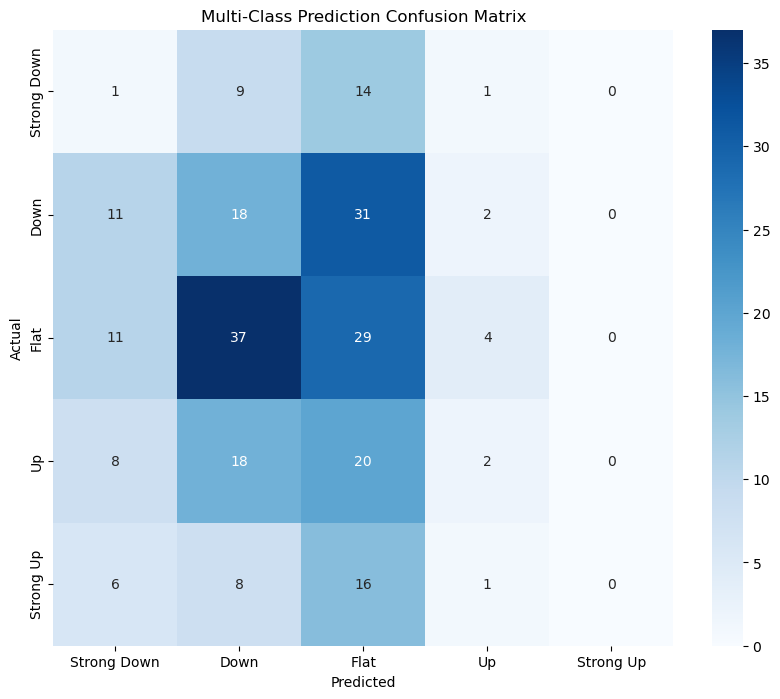

In [123]:
# Evaluate classification model
y_pred_class = attention_model.predict(X_test_class)
y_pred_labels = np.argmax(y_pred_class, axis=1)

# Classification accuracy
class_accuracy = np.mean(y_pred_labels == y_test_class)

# Convert to binary directional accuracy (up vs down)
def to_binary_direction(labels):
    # 0,1 = Down, 2 = Neutral, 3,4 = Up
    binary = np.where(labels <= 1, 0, np.where(labels >= 3, 1, -1))  # -1 for neutral
    return binary[binary != -1]  # Remove neutral predictions

y_test_binary = to_binary_direction(y_test_class)
y_pred_binary = to_binary_direction(y_pred_labels)

# Only calculate accuracy for non-neutral predictions
if len(y_test_binary) > 0 and len(y_pred_binary) > 0:
    min_len = min(len(y_test_binary), len(y_pred_binary))
    directional_acc = np.mean(y_test_binary[:min_len] == y_pred_binary[:min_len])
else:
    directional_acc = 0

print("=== CLASSIFICATION MODEL RESULTS ===")
print(f"Multi-class Accuracy: {class_accuracy:.1%}")
print(f"Directional Accuracy (Up/Down): {directional_acc:.1%}")

print("\nDetailed Classification Report:")
class_names = ['Strong Down', 'Down', 'Flat', 'Up', 'Strong Up']
print(classification_report(y_test_class, y_pred_labels, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_class, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Multi-Class Prediction Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()